## Dimensionality, Rank, and Regression

In this demo, we will explore concepts from linear algebra such as **subspaces, linear independence, span, dimension, and rank** using a real dataset: the **California Housing dataset**. 

We will connect these concepts to **regression**:
- Think of our regression problem as solving \(Ax = y\), where \(A\) is our feature matrix, \(x\) are the coefficients, and \(y\) is the target.
- We'll show how the **rank** of \(A\) affects the solution and accuracy.
- We'll also see how **dimensionality reduction** (using SVD) can impact prediction performance.

Let's start by loading the dataset and visualizing its basic structure.


### Target Variable: `MedHouseVal`

In the California Housing dataset, the **target variable** is **`MedHouseVal`**, which represents the **median house value (in units of 100,000 USD) for households within a block group**.  

- Each **block group** is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (typically covering a population of 600–3,000 people).  
- The target is a **continuous numerical variable**, making this a **regression problem**.  
- Values are scaled such that, for example, a `MedHouseVal` of **2.5** corresponds to an actual median house value of **$250,000**.  

Our goal when modeling this dataset is to **predict the median house value** given the other features (such as median income, average number of rooms, latitude/longitude, etc.).


In [25]:
# Load California Housing dataset
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

# Fetch dataset
data = fetch_california_housing(as_frame=True)
df = data.frame

# Features and target
X = df.drop(columns=['MedHouseVal']).values  # feature matrix
y = df['MedHouseVal'].values                 # target vector

# Quick overview
print("Feature matrix shape (n_samples, n_features):", X.shape)
print("Target vector shape:", y.shape)
# Display first 5 rows in a Markdown-style table
df.head()


Feature matrix shape (n_samples, n_features): (20640, 8)
Target vector shape: (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Linear Regression and the Role of Rank

Linear regression solves the system:

$$
Ax = y
$$

where:

- \(A\) is the **feature matrix** (our \(X\)),
- \(x\) is the vector of **coefficients**,
- \(y\) is the **target**.

Key points to highlight:

- The **rank** of \(A\) tells us about **linear independence** of features.
  - Full rank: all features provide independent information.
  - Reduced rank: some features are linear combinations of others (redundancy).
- Rank deficiency can affect the **stability of regression** and the uniqueness of the solution.

Next, we will compute the rank of our feature matrix and visualize it.


In [8]:
# Compute rank of feature matrix
from numpy.linalg import matrix_rank

rank_X = matrix_rank(X)
n_features = X.shape[1]

print(f"Number of features: {n_features}")
print(f"Rank of feature matrix: {rank_X}")

if rank_X < n_features:
    print("Some features are linearly dependent (redundant information).")
else:
    print("All features are linearly independent.")


Number of features: 8
Rank of feature matrix: 8
All features are linearly independent.


## Dimensionality Reduction using SVD

Even though our features are independent, we can **reduce dimensions** using **Singular Value Decomposition (SVD)**:

$$
X = U \Sigma V^T
$$

- \(U\) and \(V\) are orthogonal matrices.
- $(\Sigma)$ contains the **singular values**, which indicate the “importance” of each dimension.
- By keeping only the top $(k < \text{rank}(X)$) singular values, we reduce dimensions while retaining most of the information.

We will explore how reducing dimensions affects **regression accuracy**.


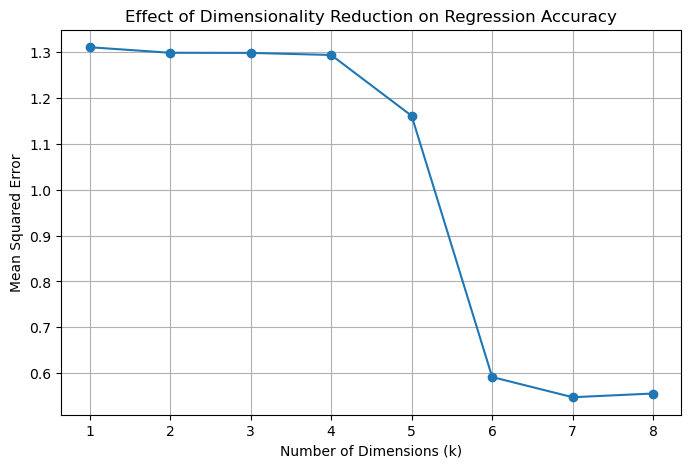

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform SVD
U, S, VT = np.linalg.svd(X_train, full_matrices=False)

# Test regression for different reduced dimensions
mse_list = []
k_values = range(1, X_train.shape[1]+1)

for k in k_values:
    # Project train and test onto top k singular vectors
    X_train_k = X_train @ VT[:k, :].T
    X_test_k = X_test @ VT[:k, :].T
    
    # Train regression
    lr = LinearRegression().fit(X_train_k, y_train)
    
    # Predict and compute MSE
    y_pred = lr.predict(X_test_k)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)

# Plot MSE vs number of dimensions
plt.figure(figsize=(8,5))
plt.plot(k_values, mse_list, marker='o')
plt.xlabel("Number of Dimensions (k)")
plt.ylabel("Mean Squared Error")
plt.title("Effect of Dimensionality Reduction on Regression Accuracy")
plt.grid(True)
plt.show()

## Predicting a New House with Full vs Reduced Rank

Now that we've seen how dimensionality reduction affects overall regression accuracy, let's make it more tangible with a **single new example**:

- We will pick a **new house** (a sample from the test set).
- We'll predict its **median house value** using:
  1. **Full rank (all 8 dimensions)** — uses all independent features.
  2. **Reduced rank (6 dimensions)** — uses only the top 6 singular vectors, losing some information.
- Comparing these predictions will illustrate **how reducing dimensions can change predictions** even for a single data point.


In [14]:
# Pick a random sample from the test set
np.random.seed(42)
sample_idx = np.random.randint(0, X_test.shape[0])
x_sample = X_test[sample_idx].reshape(1, -1)
y_true = y_test[sample_idx]

# --- Prediction using full rank (8) ---
X_train_full = X_train @ VT[:8, :].T
x_sample_full = x_sample @ VT[:8, :].T
lr_full = LinearRegression().fit(X_train_full, y_train)
y_pred_full = lr_full.predict(x_sample_full)

# --- Prediction using reduced rank (6) ---
X_train_reduced = X_train @ VT[:6, :].T
x_sample_reduced = x_sample @ VT[:6, :].T
lr_reduced = LinearRegression().fit(X_train_reduced, y_train)
y_pred_reduced = lr_reduced.predict(x_sample_reduced)

# Display results
print(f"True target value: {y_true:.3f}")
print(f"Prediction using full rank (8): {y_pred_full[0]:.3f}")
print(f"Prediction using reduced rank (6): {y_pred_reduced[0]:.3f}")


True target value: 3.746
Prediction using full rank (8): 2.157
Prediction using reduced rank (6): 2.079


## Predicting a Single New House: Full vs Reduced Rank

Let's examine a **concrete example** using a single house from our test set:

- We will predict the **median house value** of this new house using:
  1. **Full rank (8 dimensions)** — using all independent features.
  2. **Reduced rank (7 dimensions)** — removing the smallest singular value.
  
- This will help us **see the effect of dimensionality reduction** on a real prediction.

- As we will see, **sometimes reducing rank can improve predictions** by filtering out noise and stabilizing the model — a key insight in real-world datasets like California Housing.


In [17]:
# Pick the same random sample from the test set
x_sample = X_test[sample_idx].reshape(1, -1)
y_true = y_test[sample_idx]

# --- Prediction using full rank (8) ---
x_sample_rank8 = x_sample @ VT[:8, :].T
lr_full = LinearRegression().fit(X_train @ VT[:8, :].T, y_train)
y_pred_rank8 = lr_full.predict(x_sample_rank8)

# --- Prediction using reduced rank (7) ---
x_sample_rank7 = x_sample @ VT[:7, :].T
lr_reduced = LinearRegression().fit(X_train @ VT[:7, :].T, y_train)
y_pred_rank7 = lr_reduced.predict(x_sample_rank7)

# Display results
print(f"True target value: {y_true:.3f}")
print(f"Prediction using full rank (8): {y_pred_rank8[0]:.3f}")
print(f"Prediction using reduced rank (7): {y_pred_rank7[0]:.3f}")


True target value: 3.746
Prediction using full rank (8): 2.157
Prediction using reduced rank (7): 2.323


## Summary: Dimensionality, Rank, and Regression

1. **Linear algebra concepts in regression:**
   - The **rank** of the feature matrix tells us about **linear independence** of features.
   - Full rank ensures all feature information is available, but doesn’t guarantee the best predictions.

2. **Dimensionality reduction via SVD:**
   - Keeps the **most informative directions** (largest singular values).
   - Removes **less important dimensions** that often capture noise or redundancy.
   - Acts as **implicit regularization**, improving stability and generalization.

3. **Trade-off: Allowing some error**
   - Reducing dimensions may **increase error on individual samples**, because some signal is lost.
   - This is intentional: we **accept small errors locally** to **reduce overfitting and mitigate the curse of dimensionality**.
   - The overall model becomes **more robust and reliable** across the dataset.

4. **Practical insight:**
   - More features or higher rank doesn’t always mean better predictions.
   - A carefully chosen lower rank can improve generalization, even if some pointwise predictions get worse.

Takeaway: **Dimensionality reduction is about balancing accuracy and stability**, making linear algebra concepts like rank, span, and independence directly relevant for real-world regression tasks.
